# Simplified Cooling of electrons

In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from scipy.sparse import diags
from matplotlib import cycler, rcParams

In [2]:
def _power_law(gamma, k_e, p, gamma_min, gamma_max):
    """Simple power law, taking the units of normalisation k_e

    Parameters
    ----------
    k_e : `~astropy.units.Quantity`
        power law normalsiation [cm-3] [cm-3 s-1]
    gamma : `array_like`
        array of electrons Lorentz factor
    p : `float`
        (positive) spectral index, converted to negative in the function
    gamma_min, gamma_max : `float`
        minimum and maximum Lorentz factor of the power law
    """
    pwl = np.power(gamma, -p)
    null_condition = (gamma_min <= gamma) * (gamma <= gamma_max)
    pwl[~null_condition] = 0
    return k_e * pwl

Let us follow [Chiaberge and Ghisellini (1998)](https://arxiv.org/abs/astro-ph/9810263) for the time evolution:

$$\frac{\partial N(\gamma, t)}{\partial t} = 
\frac{\partial }{\partial \gamma} \left[ \dot{\gamma}(\gamma, t) N(\gamma, t) \right]
+ Q(\gamma, t) - \frac{N(\gamma,t)}{t_{\rm esc}}.$$

consider the energy losses:

$$\dot{\gamma} = \frac{4}{3} \frac{c\sigma_T}{m_e c^2} \left[ U_B + U_{\rm rad}(\gamma, t) \right]\gamma^2,$$

FSRQs are Compton dominated: $U_{\rm rad} \approx U_{\rm Comp.\,target}$ and since we know the blob is outside the BLR and the inverse Compton is dominated by the torus: $U_{\rm rad} \approx U_{\rm Torus}$, the energy loss formula simplifies to
$$\dot{\gamma} = \frac{4}{3} \frac{c\sigma_T}{m_e c^2} \left[ U_B + U_{\rm Torus}\right]\gamma^2,$$
Here we have assumed Compton scattering is happening in Thomson regime.

We can estimate $U_{\rm Torus}$ from the energy density of the target fields depicted in the [MAGIC paper reporting the 2012 active state](https://arxiv.org/abs/1401.5646#)

<img src="u.png" width="400">

being for this flare the emitting region $r>2\times10^{17}\,{\rm cm}$, the blob sits outside the BLR but within the Torus, from the picture $U_{\rm Torus} = 0.1\,{\rm erg}\,{\rm cm^{-3}}$. In the [MAGIC paper reporting the 2015 flares](https://arxiv.org/pdf/1610.09416.pdf) and in the [MAGIC paper reporting the low gamma-ray state](https://arxiv.org/abs/1806.05367) a magnetic field of $B\approx 0.3\,{\rm G}$ was used for the modelling, this imply $U_B = 3 \times 10^{-3}\,{\rm erg}\,{\rm cm}^{-3}$.

In [3]:
def gamma_loss(gamma, U_B=3e-3 * u.Unit("erg cm-3"), U_rad=0.1 * u.Unit("erg cm-3")):
    prefactor = (4 * const.c * const.sigma_T) / (3 * const.m_e * const.c * const.c)
    value = prefactor * (U_B + U_rad) * np.power(gamma, 2)
    return -value.to("s-1")

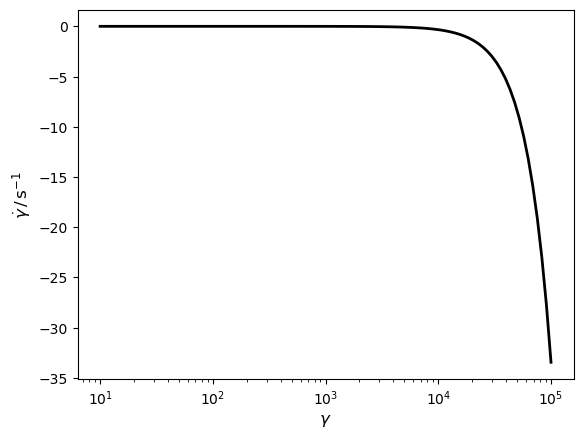

In [4]:
# plot the energy losses
gamma = np.logspace(1, 5, 100)
plt.semilogx(gamma, gamma_loss(gamma), lw=2, color="k")
plt.xlabel(r"$\gamma$", fontsize=12)
plt.ylabel(r"$\dot{\gamma}\,/\,{\rm s}^{-1}}$", fontsize=12)
plt.show()

Here I define a class to solve the time evolution equation, following Eq. 6 - 11 in [Chiaberge and Ghisellini (1998)](https://arxiv.org/abs/astro-ph/9810263)

In [5]:
class ChangCooperSolver:
    def __init__(
        self,
        gamma_min,
        gamma_max,
        n_gamma,
        t_max_ev,
        n_t,
        t_max_inj,
        t_esc,
        injection_dict,
    ):
        """class implementing the Chang and Cooper scheme in Chaiberge and Ghisellini (1998):

        Parameters
        ----------
        gamma_min : float
            minimum Lorentz factor of the electorn distribution
        gamma_max : float
            maximum Lorentz factor of the electron distribution
        n_gamma : int
            number of steps in the Lorentz factor grid
        t_max_ev : `~astropy.Units.Quantity`
            maximum time of the evolution
        n_t : int
            number of time steps
        t_max_inj : `~astropy.Units.Quantity`
            maximum time of injection
        t_esc : `~astropy.Units.Quantity`
            escape time
        injection_dict : dict
            dictionary with injection specifications (spectrum and maximum injection time)
        """
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max
        self.n_gamma = n_gamma
        _gamma = np.logspace(np.log10(gamma_min), np.log10(gamma_max), n_gamma)
        # $\gamma_{i \pm 1/2}$ in Chiaberge et al. (1998)
        self.gamma_midpts = _gamma[::2]
        # $\delta gamma_i$ in Chiaberge et al. (1998)
        self.delta_gamma = self.gamma_midpts[:-1] - self.gamma_midpts[1:]
        # $\gamma_i$ in Chiaberge et al. (1998)
        self.gamma = _gamma[1:-1:2]
        self.t_max_ev = t_max_ev.to("s")
        self.n_t = n_t
        self.delta_t = self.t_max_ev.to("s") / self.n_t
        self.t_max_inj = t_max_inj.to("s")
        self.t_esc = t_esc.to("s")
        self.injection_dict = injection_dict

        # choose which injection we are using
        if self.injection_dict["type"] == "PowerLaw":
            self.Q = _power_law(self.gamma, **self.injection_dict["parameters"])

    @property
    def gamma_dot_midpts(self):
        return gamma_loss(self.gamma_midpts)

    @property
    def V2(self):
        escape_term = (self.delta_t / self.t_esc).decompose().value
        loss_term = (
            self.delta_t * self.gamma_dot_midpts[:-1]
        ).decompose().value / self.delta_gamma
        return 1 + escape_term + loss_term

    @property
    def V3(self):
        return (
            -(self.delta_t * self.gamma_dot_midpts[1:]).decompose().value
            / self.delta_gamma
        )

    @property
    def chang_cooper_matrix(self):
        return diags([self.V2, self.V3], offsets=[0, 1]).toarray()

    def run(self):
        """solve the temporal evolution, return the result at each step"""
        print("solving Chang and Cooper equation iteratively!")
        solutions = dict()
        elapsed_time = 0 * u.s
        # initial electron distributions, suppose it's 0 everywhere at the first step
        N_prev = np.zeros(len(self.gamma))
        while elapsed_time < self.t_max_ev:
            # add the source term only for times before t_max_injection, strip units
            if elapsed_time < self.t_max_inj:
                N_prev += (self.Q * self.delta_t).to("cm-3").value
            # compute electron distribution at next time step, units have been stripped
            N_next = np.linalg.solve(self.chang_cooper_matrix, N_prev)
            print("check correctness of solution...")
            print(np.allclose(np.dot(self.chang_cooper_matrix, N_next), N_prev))
            # store solution
            solutions[f"{elapsed_time}"] = N_next * u.Unit("cm-3")
            # the solution becomes the spectrum at the next step
            N_prev = N_next
            elapsed_time += self.delta_t
        return solutions

Let us suppose to inject electrons for 50 hours and then to turn the injection off. Let us evolve the system for 100 hours and then assume an escape time much larger than the total evolution time ($t_{\rm esc}=$ 1000 hours).

In [6]:
# parameters with the injection
injection_dict = dict(
    type="PowerLaw",
    parameters=dict(k_e=1e4 * u.Unit("cm-3 s-1"), p=2.1, gamma_min=1, gamma_max=1e5),
)
cc_solver = ChangCooperSolver(
    gamma_min=1,
    gamma_max=1e6,
    n_gamma=200,
    t_max_ev=100 * u.h,
    n_t=10,
    t_max_inj=50 * u.h,
    t_esc=1000 * u.h,
    injection_dict=injection_dict,
)

In [7]:
solutions = cc_solver.run()

solving Chang and Cooper equation iteratively!
check correctness of solution...
True
check correctness of solution...
True
check correctness of solution...
True
check correctness of solution...
True
check correctness of solution...
True
check correctness of solution...
True
check correctness of solution...
True
check correctness of solution...
True
check correctness of solution...
True
check correctness of solution...
True


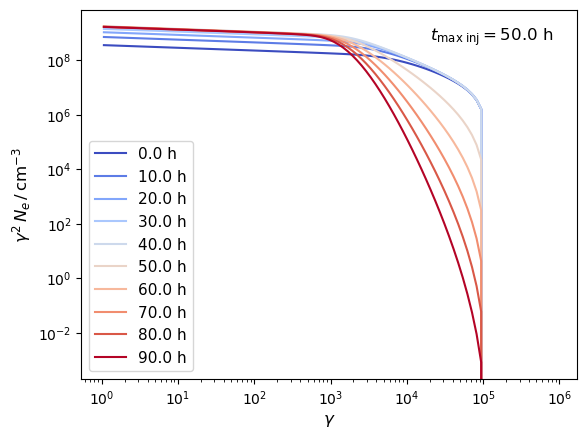

In [8]:
# use crescent coloring
cmap = plt.cm.coolwarm
n_colors = cc_solver.n_t
rcParams["axes.prop_cycle"] = cycler(color=cmap(np.linspace(0, 1, n_colors)))

fig, ax = plt.subplots()

for key in solutions.keys():
    label = u.Quantity(key).to("h")
    plt.loglog(
        cc_solver.gamma,
        np.power(cc_solver.gamma, 2) * solutions[key],
        lw=1.5,
        label=label,
    )
ax.legend(fontsize=11)
ax.set_ylabel(r"$\gamma^2 \, N_e \, / \, {\rm cm}^{-3}$", fontsize=12)
ax.set_xlabel(r"$\gamma$", fontsize=12)
ax.annotate(
    r"$t_{\rm max\;inj}=$" + str(cc_solver.t_max_inj.to("h")), (2e4, 5e8), fontsize=12
)
"""
# reference powerlaw to check spectral index
ax.loglog(
    cc_solver.gamma,
    np.power(cc_solver.gamma, 2) * _power_law(
        cc_solver.gamma, 
        1e18 * u.Unit("cm-3"),
        5,
        1e3, 
        1e5
    ),
    color="k",
    ls="--"
)
"""
plt.show()
fig.savefig("evolved_spectra.png")

In [9]:
# save one of the electron distribution in a .txt file (for agnpy testing)
np.savetxt(
    "eed_lepton_cooling.txt",
    list(zip(cc_solver.gamma, solutions["324000.0 s"].value)),
)